In [42]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils



# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_properties(0))



cuda:0
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1070 Ti', major=6, minor=1, total_memory=8191MB, multi_processor_count=19)


6


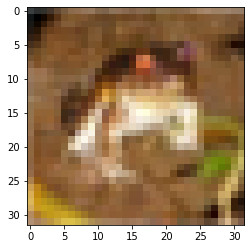

In [26]:
CIFAR10 = datasets.CIFAR10('data',transform=transforms.ToTensor())



#display the first image in the dataset and its label
plt.imshow(CIFAR10.__getitem__(0)[0].permute(1,2,0))
print(CIFAR10.__getitem__(0)[1])

#split the dataset into training, validation and test sets
length_training = CIFAR10.__len__()*0.8
length_validation = CIFAR10.__len__()*0.1

training = list(CIFAR10)[:int(length_training)]
validation = list(CIFAR10)[int(length_training):int(length_training+length_validation)]
test = list(CIFAR10)[int(length_training+length_validation):]

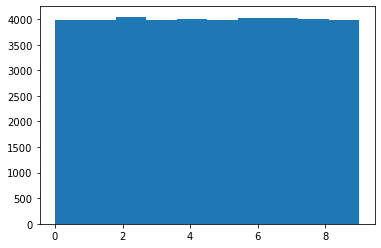

In [5]:

#plot the dirtribution of the labels in the training set
labels = [x[1] for x in training]
plt.hist(labels,bins=10)
plt.show()

We cam see that we are wroking with a very balanced data set.

Models in PyTorch
We'll train a convolutional neural network.

In [102]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,10)

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = self.fc1(x)
        return x


def get_accuracy(model,data,train):
    model.to(device)
    correctly_classified = []
    falsely_classified = []

    if train:
        model.train()
    else:
        model.eval()
    correct = 0
    total = 0
    for images,labels in data:
        images,labels = images.to(device),labels
        outputs = model(images.unsqueeze(0))
        _,predicted = torch.max(outputs.data,1)
        total += 1
        correct += (predicted == labels).sum()
        if predicted == labels:
            correctly_classified.append(images)
        else:
            falsely_classified.append(images)
            
    return (100*correct/total),correctly_classified,falsely_classified






In [97]:
def train(model, data, validation, batch_size, epochs, learning_rate = 0.01,weight_decay =0.2,momentum = 0.05,optimizer = "Adam"):
    """
    :param model: the model to train
    :param data: the dataset to train on
    :param batch_size: the batch size
    :param epochs: the number of epochs
    :param learning_rate: the learning rate
    :param weight_decay: the weight decay
    :param momentum: the momentum
    :return: the trained model
    """
    losses = []
    iter = []

    min_val_loss = float("inf")



    #define the loss function
    criterion = nn.CrossEntropyLoss()
    #define the optimizer
    if optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    else :
        optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay)

    #images loader
    train_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=True,num_workers=0)

    #train the model
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_loader):

            #move tensors to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            if images.size()[0] < batch_size:
                continue

            #forward pass
            else:
                model = model.to(device)
                model.train()

           
                #forward pass
                outputs = model(images)
                #compute the loss
                loss = criterion(outputs,labels)
                #backward pass
                loss.backward()
                #update the weights
                optimizer.step()
                #clear the gradients
                optimizer.zero_grad()

                #store current loss
                iter.append(i)
                losses.append(float(loss)/batch_size)

        val_loader = torch.utils.data.DataLoader(validation,batch_size=batch_size,shuffle=True,num_workers=0)
        for i,(images,labels) in enumerate(val_loader):
            #move tensors to GPU
            images = images.to(device)
            labels = labels.to(device)
            if images.size()[0] < batch_size:
                continue
            else:
                model = model.to(device)
                model.eval()
                #forward pass
                outputs = model(images)
                #compute the loss
                loss = criterion(outputs,labels)
        val_loss = (float(loss)/batch_size)
        print("Epoch: {}/{}.. ".format(epoch+1,epochs),
              "Training Loss: {:.3f}.. ".format(losses[-1]),
              "Validation Loss: {:.3f}.. ".format(val_loss))

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), 'model.ckpt')


        
        #print training loss
        print("Training loss: ",losses[-1])




        
       

    


                
    return model,losses,iter




In [113]:
model = CNN()

model,losses,iter= train(model,training,validation,learning_rate=0.001,batch_size=100,epochs=10)

# The model is under fitting, we need to add more layers




Epoch: 1/10..  Training Loss: 0.021..  Validation Loss: 0.021.. 
Training loss:  0.021358890533447264
Epoch: 2/10..  Training Loss: 0.020..  Validation Loss: 0.021.. 
Training loss:  0.020292448997497558
Epoch: 3/10..  Training Loss: 0.020..  Validation Loss: 0.021.. 
Training loss:  0.020270814895629884
Epoch: 4/10..  Training Loss: 0.022..  Validation Loss: 0.021.. 
Training loss:  0.02157583713531494
Epoch: 5/10..  Training Loss: 0.020..  Validation Loss: 0.021.. 
Training loss:  0.020217950344085692
Epoch: 6/10..  Training Loss: 0.021..  Validation Loss: 0.020.. 
Training loss:  0.02090920925140381
Epoch: 7/10..  Training Loss: 0.020..  Validation Loss: 0.021.. 
Training loss:  0.020076239109039308
Epoch: 8/10..  Training Loss: 0.022..  Validation Loss: 0.020.. 
Training loss:  0.021648452281951905
Epoch: 9/10..  Training Loss: 0.020..  Validation Loss: 0.021.. 
Training loss:  0.02046250343322754
Epoch: 10/10..  Training Loss: 0.022..  Validation Loss: 0.020.. 
Training loss:  0.0

In [115]:
#Adding more layers
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3,padding=1).to(device)
        self.bn1 = nn.BatchNorm2d(6).to(device)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,2,padding=1).to(device)
        self.bn2 = nn.BatchNorm2d(16).to(device)
        self.conv3 = nn.Conv2d(16,16,2,padding=1).to(device)
        self.bn3 = nn.BatchNorm2d(16).to(device)
        self.fc1 = nn.Linear(16*9*9,32).to(device)
        self.fc2 = nn.Linear(32,10).to(device)

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        #print(x.size())
        x = torch.relu(self.conv2(x))
        #print(x.size())
        x = self.pool(torch.relu(self.conv3(x)))
        #print(x.size())
        
        
        x= x.view(-1,16*9*9)
        x = self.fc1(x)
       
        x = self.fc2(x)
        return x

In [116]:
model = CNN2()

model,losses,iter = train(model,training,validation,learning_rate=0.001,batch_size=100,epochs=10)

# Still the model is under fitting, we need to add more channels to the convolutional layers


Epoch: 1/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.02302586555480957
Epoch: 2/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.023017499446868896
Epoch: 3/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.023020505905151367
Epoch: 4/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.023026707172393798
Epoch: 5/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.02302748680114746
Epoch: 6/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.02302429437637329
Epoch: 7/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.02301910161972046
Epoch: 8/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.023026301860809326
Epoch: 9/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.02304901123046875
Epoch: 10/10..  Training Loss: 0.023..  Validation Loss: 0.023.. 
Training loss:  0.023

In [83]:
#The previous models were underfitting, so we replace some of the convolutional layers with fully connected layers
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3,self).__init__()
        self.conv1 = nn.Conv2d(3,35,3,padding=1)
        self.bn1 = nn.BatchNorm2d(35)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(35,70,2,padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(70)
        self.fc1 = nn.Linear(70*8*8,32)
        self.fc2 = nn.Linear(32,10)

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)

        x= x.view(-1,70*8*8)
        x = self.fc1(x)
       
        x = self.fc2(x)
        return x

In [85]:
# Train the third model
model = CNN3()
model,losses,iter = train(model,training,validation,learning_rate=0.001,batch_size=100,epochs=20)

#The model is clearly overfitting, so we will add more convolutional layers

Epoch: 1/20..  Training Loss: 0.011..  Validation Loss: 0.011.. 
Training loss:  0.01148017168045044
Epoch: 2/20..  Training Loss: 0.009..  Validation Loss: 0.012.. 
Training loss:  0.008724817037582398
Epoch: 3/20..  Training Loss: 0.008..  Validation Loss: 0.011.. 
Training loss:  0.007519466876983643
Epoch: 4/20..  Training Loss: 0.006..  Validation Loss: 0.015.. 
Training loss:  0.006051757335662842
Epoch: 5/20..  Training Loss: 0.008..  Validation Loss: 0.007.. 
Training loss:  0.00799235463142395
Epoch: 6/20..  Training Loss: 0.008..  Validation Loss: 0.014.. 
Training loss:  0.00761126697063446
Epoch: 7/20..  Training Loss: 0.008..  Validation Loss: 0.009.. 
Training loss:  0.007842195630073547
Epoch: 8/20..  Training Loss: 0.006..  Validation Loss: 0.012.. 
Training loss:  0.005597544312477112
Epoch: 9/20..  Training Loss: 0.006..  Validation Loss: 0.012.. 
Training loss:  0.005531213879585266
Epoch: 10/20..  Training Loss: 0.004..  Validation Loss: 0.010.. 
Training loss:  0.0

In [95]:
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4,self).__init__()
        self.conv1 = nn.Conv2d(3,35,3,padding=1)
        self.bn1 = nn.BatchNorm2d(35)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(35,70,2,padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(70)
        self.conv3 = nn.Conv2d(70,140,2,padding=1,stride=1)
        self.bn3 = nn.BatchNorm2d(140)
        self.fc1 = nn.Linear(140*4*4,32)
        self.fc2 = nn.Linear(32,10)
        self.dropout = nn.Dropout(0.25)

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.bn3(x)


        x= x.view(-1,140*4*4)
        x = self.fc1(x)
        x = self.dropout(x)
       
        x = self.fc2(x)
        return x

In [99]:
model = CNN4()
model,losses,iter = train(model,training,validation,learning_rate=0.001,batch_size=100,epochs=20,weight_decay=0.001)


Epoch: 1/20..  Training Loss: 0.009..  Validation Loss: 0.014.. 
Training loss:  0.008979227542877197
Epoch: 2/20..  Training Loss: 0.007..  Validation Loss: 0.010.. 
Training loss:  0.007261558771133423
Epoch: 3/20..  Training Loss: 0.007..  Validation Loss: 0.008.. 
Training loss:  0.006598581075668335
Epoch: 4/20..  Training Loss: 0.007..  Validation Loss: 0.011.. 
Training loss:  0.006748371124267578
Epoch: 5/20..  Training Loss: 0.008..  Validation Loss: 0.008.. 
Training loss:  0.007987191677093506
Epoch: 6/20..  Training Loss: 0.008..  Validation Loss: 0.008.. 
Training loss:  0.007840214371681213
Epoch: 7/20..  Training Loss: 0.006..  Validation Loss: 0.008.. 
Training loss:  0.006307717561721802
Epoch: 8/20..  Training Loss: 0.006..  Validation Loss: 0.005.. 
Training loss:  0.005767619609832764
Epoch: 9/20..  Training Loss: 0.005..  Validation Loss: 0.010.. 
Training loss:  0.0046694746613502505
Epoch: 10/20..  Training Loss: 0.004..  Validation Loss: 0.011.. 
Training loss: 

Test accuracy:  tensor(73.4200, device='cuda:0')


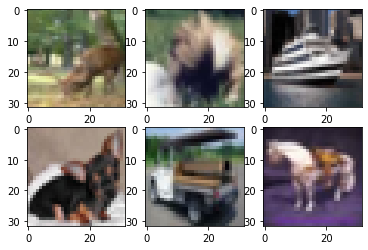

In [112]:
#loading optimal model
model.load_state_dict(torch.load('model.ckpt'))

#get test accuracy
acc, cor, fal = get_accuracy(model,test,train=False)

print("Test accuracy: ",acc)

#display 6 misclassified images

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(fal[i].cpu().permute(1,2,0))
    



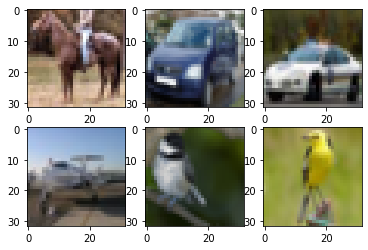

In [111]:
#display 6 correctly classified images
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(cor[i].cpu().permute(1,2,0))